In [1]:
from util import setup_notebook
setup_notebook()

In [2]:
import altair as alt
import pandas as pd
from testmining.util import strip_prefixes

In [3]:
df = pd.read_csv('../output/square@okhttp/baseline/okhttp@untreated.csv')
df['shortTestName'] = strip_prefixes(df['testName'], sep='.')
df.head()

,travisBuildNumber,travisBuildId,travisJobId,testName,index,duration,count,failures,errors,skipped,shortTestName
0,1,2685383,2685384,libcore.net.http.HttpResponseCacheTest,0,2.796,100,0,1,0,HttpResponseCacheTest
1,1,2685383,2685384,libcore.net.http.RawHeadersTest,1,0.001,2,0,0,0,RawHeadersTest
2,1,2685383,2685384,libcore.net.http.URLConnectionTest,2,5.621,110,0,0,0,http.URLConnectionTest
3,1,2685383,2685384,libcore.net.http.NewURLConnectionTest,3,0.000,1,0,0,0,NewURLConnectionTest
4,1,2685383,2685384,libcore.net.spdy.SpdyConnectionTest,4,0.218,11,0,0,0,SpdyConnectionTest


In [4]:
len(df[(df.errors + df.failures) > 0].testName.unique())

42

In [5]:
def gantt_failures():
    
    # Mapping from test name to the job number of the first failure of this series
    failing = {}
    
    # Tuples of (name, first failing job number, last failing job number)
    result = []
    
    def helper(job_number, index):
        job = df.loc[index]
        failed = job[(job.failures + job.errors) > 0]
        failed_names = set(failed['shortTestName'])
        
        # Treat tests which no longer fail
        removed = failing.keys() - failed_names
        for item in removed:
            result.append((item, failing[item], job_number))
            del failing[item]
        
        # Treat tests which began failing in this job
        added = failed_names - failing.keys()
        for item in added:
            failing[item] = job_number
    
    # Refrained from using `apply` - can be troublesome for f with side effects,
    # because the function can be called multiple times for the same group
    for job_number, index in df.groupby('travisBuildNumber').groups.items():
        helper(job_number, index)
    
    # Treat the last group: we will not observe those going green again.
    # Failures in the most recent job 'complete' failing within that job.
    for item in failing:
        result.append((item, failing[item], job_number))
        
    return pd.DataFrame(result, columns=['testName', 'begin', 'end'])
        
        
gantt_df = gantt_failures()
gantt_df.head()

,testName,begin,end
0,http.URLConnectionTest,2,3
1,HttpResponseCacheTest,1,6
2,http.URLConnectionTest,6,8
3,http.URLConnectionTest,9,17
4,HttpResponseCacheTest,8,20


In [6]:
len(gantt_df['testName'].unique())

42

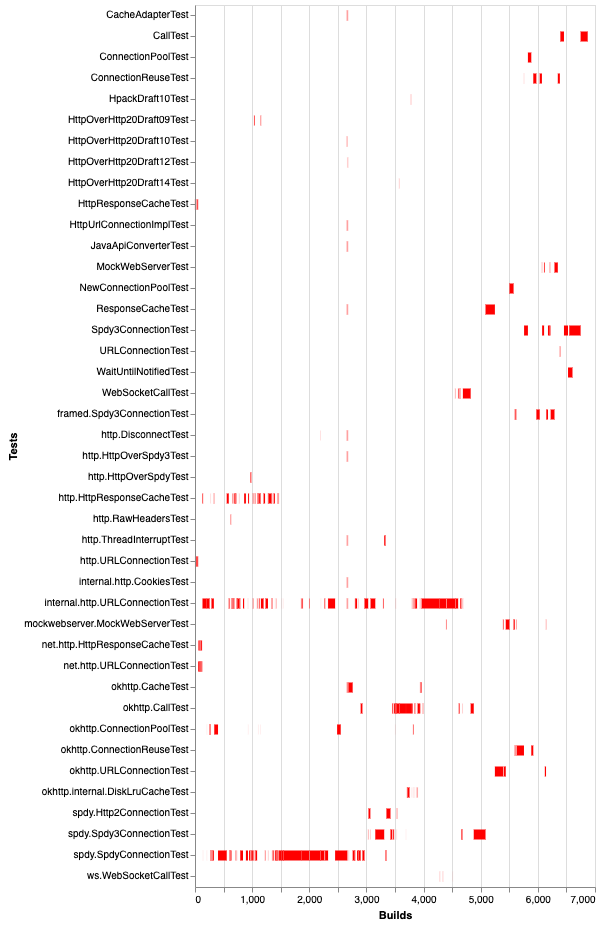

In [7]:
import altair as alt

alt.Chart(gantt_df).mark_rule(stroke='red', strokeWidth=10).encode(
    x=alt.X('begin', title='Builds'),
    x2=alt.X('end:N', title=''),
    y=alt.Y('testName', title='Tests'),
)

In [8]:
tests = pd.Series(gantt_df['testName'].unique()).sort_values().tail(20)
tests

9                http.HttpOverSpdyTest
5           http.HttpResponseCacheTest
8                  http.RawHeadersTest
12            http.ThreadInterruptTest
0               http.URLConnectionTest
14           internal.http.CookiesTest
4      internal.http.URLConnectionTest
29     mockwebserver.MockWebServerTest
2       net.http.HttpResponseCacheTest
3           net.http.URLConnectionTest
16                    okhttp.CacheTest
22                     okhttp.CallTest
7            okhttp.ConnectionPoolTest
34          okhttp.ConnectionReuseTest
31            okhttp.URLConnectionTest
26    okhttp.internal.DiskLruCacheTest
24            spdy.Http2ConnectionTest
23            spdy.Spdy3ConnectionTest
6              spdy.SpdyConnectionTest
28                ws.WebSocketCallTest
dtype: object

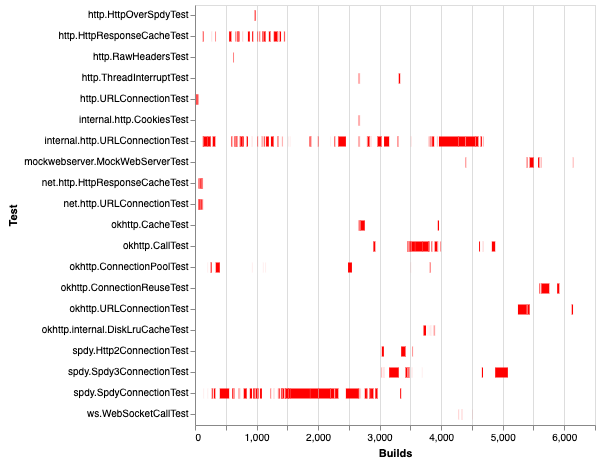

In [9]:
alt.Chart(gantt_df[gantt_df['testName'].isin(tests)]).mark_rule(stroke='red', strokeWidth=10).encode(
    x=alt.X('begin', title='Builds'),
    x2='end:N',
    y=alt.Y('testName', title='Test')
)